# Data Processing

In [1]:
import pandas as pd

meta_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/data/HAM10000_metadata.csv")

data = meta_data['image_id']
labels = meta_data['dx']

path = "/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/data/dataset"

full_path = [path + "/" + a + ".jpg" for a in data]


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_dummy, y_train, y_dummy = train_test_split(full_path, labels, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_dummy, y_dummy, test_size=0.5, random_state=42)

print(len(X_train))
print(len(X_valid))
print(len(X_test))
print(len(y_train))
print(len(y_valid))
print(len(y_test))


8012
1001
1002
8012
1001
1002


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

def preprocess_data(file_paths, labels, target_size=(224, 224), num_classes=7):
    """
    Load, preprocess images and convert labels to one-hot encoded format.

    Parameters:
    - file_paths: List of paths to the images.
    - labels: Corresponding labels for the images.
    - target_size: Tuple indicating the size to which images will be resized.
    - num_classes: Number of unique labels/classes.

    Returns:
    - images_array: Numpy array of preprocessed images.
    - labels_encoded: Numpy array of one-hot encoded labels.
    """

    images = []
    for file in tqdm(file_paths, desc="Processing images"):
        image = tf.keras.preprocessing.image.load_img(file, target_size=target_size)
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = image/255
        images.append(image)

    images_array = np.array(images)

    # Create a mapping from string labels to integers
    label_mapping = {label: index for index, label in enumerate(np.unique(labels))}
    labels_int = np.array([label_mapping[label] for label in labels])

    # Convert integer labels to one-hot encoded format
    labels_encoded = to_categorical(labels_int, num_classes=num_classes)

    return images_array, labels_encoded


In [13]:
# Usage
train_images, train_labels_encoded = preprocess_data(X_train, y_train)
valid_images, valid_labels_encoded = preprocess_data(X_valid, y_valid)
#test_images, test_labels_encoded = preprocess_data(X_test, y_test)

Processing images: 100%|██████████| 1001/1001 [00:07<00:00, 137.83it/s]


In [14]:
# Save arrays to .npy format
np.save('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_images.npy', train_images)
np.save('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_labels_encoded.npy', train_labels_encoded)

# Save arrays to .npy format
np.save('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_images.npy', valid_images)
np.save('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_labels_encoded.npy', valid_labels_encoded)

print(train_images.shape)
print(train_labels_encoded.shape)
print(valid_images.shape)
print(valid_labels_encoded.shape)

(8012, 224, 224, 3)
(8012, 7)
(1001, 224, 224, 3)
(1001, 7)


# Convolutional Neural Networks

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

train_images = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_images.npy')
train_labels_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_labels_encoded.npy')

valid_images = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_images.npy')
valid_labels_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_labels_encoded.npy')

model = tf.keras.models.Sequential()

# Input Layer
model.add(tf.keras.layers.Input(shape=[224, 224, 3]))

# Convolutional Layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPooling2D())

# Flatten and Fully Connected Layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2()))
model.add(tf.keras.layers.BatchNormalization())

# Output Layer
model.add(tf.keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

# Compile the Model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show Model Summary
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 64)      

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', patience=5)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_images)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)

# Model fitting with data augmentation
batch_size = 32
history = model.fit(datagen.flow(train_images, train_labels_encoded, batch_size=batch_size),
                    steps_per_epoch=len(train_images) / batch_size,
                    epochs=100,
                    validation_data=(valid_images, valid_labels_encoded),
                    callbacks=[early, reduce_lr])



Epoch 1/100
250/250 [==============================] - 84s 299ms/step - loss: 1.5050 - accuracy: 0.5362 - val_loss: 1.4177 - val_accuracy: 0.5305 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 73s 291ms/step - loss: 1.0035 - accuracy: 0.6824 - val_loss: 0.9588 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 74s 296ms/step - loss: 0.8510 - accuracy: 0.7038 - val_loss: 0.9002 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 73s 290ms/step - loss: 0.8015 - accuracy: 0.7139 - val_loss: 0.9174 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 5/100
250/250 [==============================] - 73s 289ms/step - loss: 0.7546 - accuracy: 0.7277 - val_loss: 0.8114 - val_accuracy: 0.7293 - lr: 0.0010
Epoch 6/100
250/250 [==============================] - 72s 288ms/step - loss: 0.7273 - accuracy: 0.7359 - val_loss: 0.7900 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 7/100
250/250 [=========================

In [15]:
import matplotlib.pyplot as plt

def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


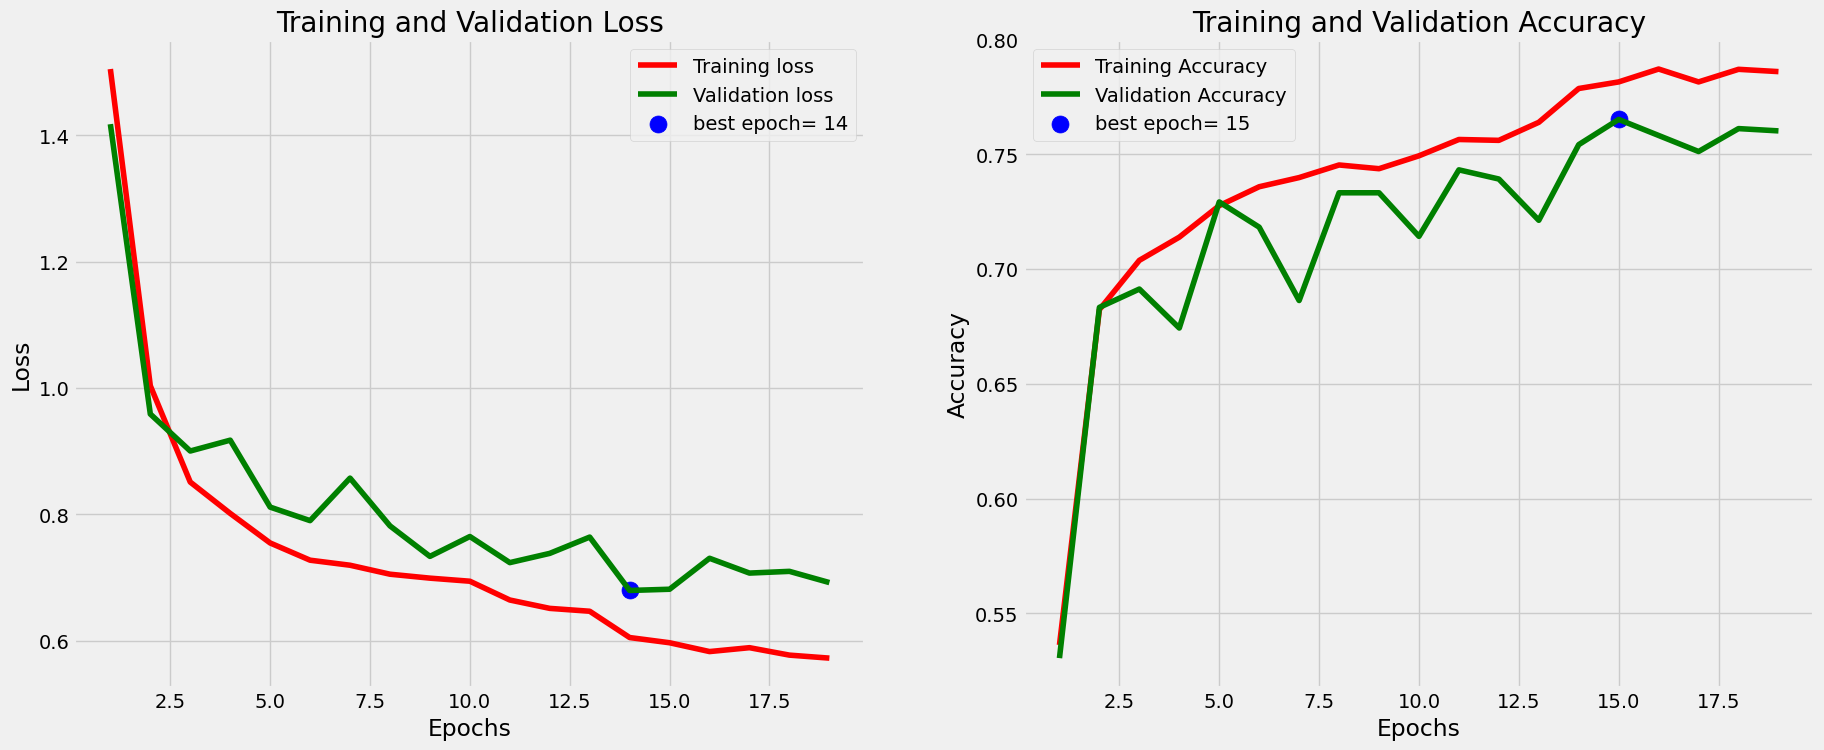

In [16]:
plot_training(history)



# Transfer Learning

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, MaxPooling2D

In [2]:
train_images = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_images.npy')
train_labels_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_labels_encoded.npy')

valid_images = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_images.npy')
valid_labels_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_labels_encoded.npy')


## Xception Model

In [9]:
base_model = Xception(weights='imagenet', include_top=False)

for layer in base_model.layers:
  layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [12]:
early = EarlyStopping(monitor='val_accuracy', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

history = model.fit(train_images, train_labels_encoded, epochs=50,
                    validation_data=(valid_images, valid_labels_encoded), callbacks=[early, reduce_lr])


Epoch 1/50
251/251 [==============================] - 45s 165ms/step - loss: 1.0199 - accuracy: 0.6770 - val_loss: 0.8751 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 2/50
251/251 [==============================] - 38s 152ms/step - loss: 0.8606 - accuracy: 0.7039 - val_loss: 0.8328 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 3/50
251/251 [==============================] - 39s 154ms/step - loss: 0.8011 - accuracy: 0.7177 - val_loss: 0.7943 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 4/50
251/251 [==============================] - 39s 154ms/step - loss: 0.7543 - accuracy: 0.7339 - val_loss: 0.7777 - val_accuracy: 0.7343 - lr: 0.0010
Epoch 5/50
251/251 [==============================] - 38s 153ms/step - loss: 0.7234 - accuracy: 0.7445 - val_loss: 0.7702 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 6/50
251/251 [==============================] - 39s 154ms/step - loss: 0.6863 - accuracy: 0.7590 - val_loss: 0.7456 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 7/50
251/251 [==============================] 

### Unfreezing Xception Layers

In [13]:
# Load the Xception model with weights pre-trained on ImageNet
base_model = Xception(weights='imagenet', include_top=False)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Construct the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model with a smaller learning rate
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels_encoded, epochs=50,
                    validation_data=(valid_images, valid_labels_encoded), callbacks=[early, reduce_lr])


Epoch 1/50
251/251 [==============================] - 60s 203ms/step - loss: 1.0747 - accuracy: 0.6184 - val_loss: 1.0931 - val_accuracy: 0.6733 - lr: 1.0000e-04
Epoch 2/50
251/251 [==============================] - 47s 189ms/step - loss: 0.8148 - accuracy: 0.6931 - val_loss: 0.7782 - val_accuracy: 0.7163 - lr: 1.0000e-04
Epoch 3/50
251/251 [==============================] - 48s 191ms/step - loss: 0.7473 - accuracy: 0.7200 - val_loss: 0.7541 - val_accuracy: 0.7343 - lr: 1.0000e-04
Epoch 4/50
251/251 [==============================] - 48s 190ms/step - loss: 0.6782 - accuracy: 0.7468 - val_loss: 0.7475 - val_accuracy: 0.7313 - lr: 1.0000e-04
Epoch 5/50
251/251 [==============================] - 48s 191ms/step - loss: 0.6220 - accuracy: 0.7722 - val_loss: 0.7091 - val_accuracy: 0.7463 - lr: 1.0000e-04
Epoch 6/50
251/251 [==============================] - 48s 190ms/step - loss: 0.5694 - accuracy: 0.7908 - val_loss: 0.6762 - val_accuracy: 0.7502 - lr: 1.0000e-04
Epoch 7/50
251/251 [========

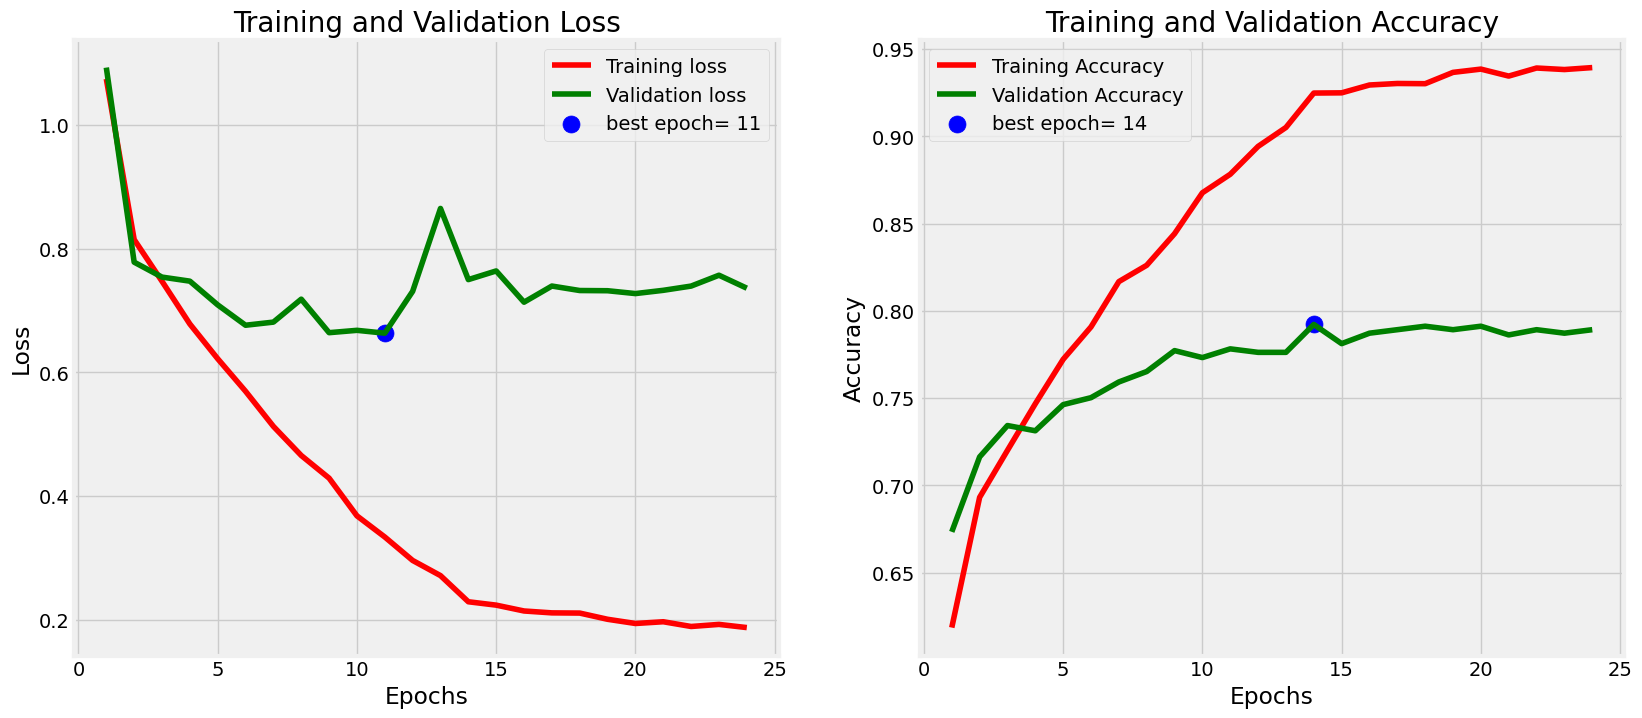

In [16]:
plot_training(history)



## EfficientNet

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

print('Loading training data...')
train_images = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_images.npy')
train_labels_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_labels_encoded.npy')

print('Loading validation data...')
valid_images = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_images.npy')
valid_labels_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_labels_encoded.npy')


Loading training data...
Loading validation data...


In [7]:
# Load the EfficientNetB0 model with weights pre-trained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Construct the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

# Compile the model with a suitable learning rate
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# Train the model
history = model.fit(train_images, train_labels_encoded, epochs=50,
                    validation_data=(valid_images, valid_labels_encoded), callbacks=[early, reduce_lr])


16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/50
251/251 [==============================] - 25s 38ms/step - loss: 1.3319 - accuracy: 0.6308 - val_loss: 1.1390 - val_accuracy: 0.6733 - lr: 1.0000e-04
Epoch 2/50
251/251 [==============================] - 6s 25ms/step - loss: 1.2202 - accuracy: 0.6638 - val_loss: 1.1333 - val_accuracy: 0.6733 - lr: 1.0000e-04
Epoch 3/50
250/251 [============================>.] - ETA: 0s - loss: 1.1986 - accuracy: 0.6671
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
251/251 [==============================] - 6s 25ms/step - loss: 1.1985 - accuracy: 0.6671 - val_loss: 1.1239 - val_accuracy: 0.6733 - lr: 1.0000e-04
Epoch 4/50
251/251 [==============================] - 6s 25ms/step - loss: 1.1960 - accuracy: 0.6675 - val_loss: 1.1253 - val_accuracy: 0.6733 - lr: 2.0000e-05
Epoch 5/50
250/251 [============================>.] - ETA: 0s - loss: 1.1922 - accuracy: 0.6680
Epoch 5: ReduceLROnPlateau reducing 

### Checking label imbalancing

In [9]:
train_labels_integer = np.argmax(train_labels_encoded, axis=1)
valid_labels_integer = np.argmax(valid_labels_encoded, axis=1)

print(Counter(train_labels_integer))
print(Counter(valid_labels_integer))


Counter({5: 5367, 4: 887, 2: 871, 1: 421, 0: 258, 6: 121, 3: 87})
Counter({5: 674, 2: 113, 4: 113, 0: 39, 1: 38, 3: 16, 6: 8})


In [11]:
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# Resampling using SMOTE
smote = SMOTE()
train_images_resampled, train_labels_encoded_resampled = smote.fit_resample(train_images.reshape(-1, 128*128*3), train_labels_encoded)

# Reshape the images back to their original shape
train_images_resampled = train_images_resampled.reshape(-1, 128, 128, 3)

# Convert one-hot encoded labels to scalar labels
train_labels_scalar = np.argmax(train_labels_encoded, axis=1)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels_scalar), y=train_labels_scalar)
class_weights = dict(enumerate(class_weights))



In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# Construct the model with EfficientNetB0 as the base
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model_efficientnet.trainable = False

# Construct the full model
model_efficientnet = Sequential([
    base_model_efficientnet,
    Flatten(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model_efficientnet.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using class weights
history_efficientnet = model_efficientnet.fit(
    train_images_resampled,
    train_labels_encoded_resampled,
    epochs=50,
    validation_data=(valid_images, valid_labels_encoded),
    callbacks=[early, reduce_lr],
    class_weight=class_weights
)


Epoch 1/50
1175/1175 [==============================] - 36s 25ms/step - loss: 7.7978 - accuracy: 0.1443 - val_loss: 3.0973 - val_accuracy: 0.0160 - lr: 1.0000e-04
Epoch 2/50
1175/1175 [==============================] - 28s 24ms/step - loss: 7.4791 - accuracy: 0.1445 - val_loss: 3.6583 - val_accuracy: 0.0160 - lr: 1.0000e-04
Epoch 3/50
1174/1175 [============================>.] - ETA: 0s - loss: 7.4377 - accuracy: 0.1421
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1175/1175 [==============================] - 28s 24ms/step - loss: 7.4376 - accuracy: 0.1421 - val_loss: 3.5848 - val_accuracy: 0.0160 - lr: 1.0000e-04
Epoch 4/50
1175/1175 [==============================] - 28s 24ms/step - loss: 7.3833 - accuracy: 0.1431 - val_loss: 3.3434 - val_accuracy: 0.0160 - lr: 2.0000e-05
Epoch 5/50
1173/1175 [============================>.] - ETA: 0s - loss: 7.3630 - accuracy: 0.1424
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-05.
1175/1175 [===============

## Implementing ensemble learning

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

print('Loading training data...')
train_images = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_images.npy')
train_labels_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/train_labels_encoded.npy')

print('Loading validation data...')
valid_images = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_images.npy')
valid_labels_encoded = np.load('/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Skin Lesion Classification/valid_labels_encoded.npy')


Loading training data...
Loading validation data...


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_images)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import InceptionV3, ResNet152, DenseNet201

# InceptionV3
base_model_incep = InceptionV3(weights='imagenet', include_top=False)
# InceptionV3
model_incep = Sequential([
    base_model_incep,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # Assuming 7 classes
])

# ResNet152
base_model_resnet = ResNet152(weights='imagenet', include_top=False)
# ResNet152
model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # Assuming 7 classes
])

# DenseNet161
base_model_densenet = DenseNet201(weights='imagenet', include_top=False)
# DenseNet161
model_densenet = Sequential([
    base_model_densenet,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # Assuming 7 classes
])


74836368/74836368 [==============================] - 2s 0us/step


In [12]:
model_incep.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
model_incep.fit(datagen.flow(train_images, train_labels_encoded, batch_size=32),
                steps_per_epoch=len(train_images) / 32, epochs=50)

model_resnet.fit(datagen.flow(train_images, train_labels_encoded, batch_size=32),
                steps_per_epoch=len(train_images) / 32, epochs=50)

model_densenet.fit(datagen.flow(train_images, train_labels_encoded, batch_size=32),
                steps_per_epoch=len(train_images) / 32, epochs=50)


Epoch 1/50
250/250 [==============================] - 132s 318ms/step - loss: 0.8741 - accuracy: 0.7029
Epoch 2/50
250/250 [==============================] - 75s 300ms/step - loss: 0.6106 - accuracy: 0.7830
Epoch 3/50
250/250 [==============================] - 78s 309ms/step - loss: 0.5131 - accuracy: 0.8152
Epoch 4/50
250/250 [==============================] - 78s 310ms/step - loss: 0.4416 - accuracy: 0.8385
Epoch 5/50
250/250 [==============================] - 78s 309ms/step - loss: 0.3902 - accuracy: 0.8560
Epoch 6/50
250/250 [==============================] - 81s 322ms/step - loss: 0.3506 - accuracy: 0.8731
Epoch 7/50
250/250 [==============================] - 81s 321ms/step - loss: 0.3128 - accuracy: 0.8870
Epoch 8/50
250/250 [==============================] - 80s 317ms/step - loss: 0.2868 - accuracy: 0.9014
Epoch 9/50
250/250 [==============================] - 80s 318ms/step - loss: 0.2660 - accuracy: 0.9056
Epoch 10/50
250/250 [==============================] - 77s 307ms/step - 

In [14]:
predictions_incep = model_incep.predict(valid_images)
predictions_resnet = model_resnet.predict(valid_images)
predictions_densenet = model_densenet.predict(valid_images)

final_predictions = (predictions_incep + predictions_resnet + predictions_densenet) / 3


32/32 [==============================] - 10s 227ms/step


In [15]:
final_class_labels = np.argmax(final_predictions, axis=1)
final_class_labels


array([5, 5, 5, ..., 4, 5, 5])

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert one-hot encoded labels to label-encoded format
true_labels = np.argmax(valid_labels_encoded, axis=1)

# Now compute the metrics using the label-encoded format
accuracy = accuracy_score(true_labels, final_class_labels)
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(true_labels, final_class_labels)
print("Classification Report:")
print(report)

conf_matrix = confusion_matrix(true_labels, final_class_labels)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8811
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.41      0.57        39
           1       0.80      0.84      0.82        38
           2       0.63      0.84      0.72       113
           3       1.00      0.50      0.67        16
           4       0.87      0.58      0.70       113
           5       0.94      0.97      0.96       674
           6       0.89      1.00      0.94         8

    accuracy                           0.88      1001
   macro avg       0.87      0.74      0.77      1001
weighted avg       0.89      0.88      0.88      1001

Confusion Matrix:
[[ 16   4  14   0   1   4   0]
 [  0  32   4   0   0   2   0]
 [  0   2  95   0   3  13   0]
 [  1   2   2   8   0   3   0]
 [  0   0  25   0  66  22   0]
 [  0   0  10   0   6 657   1]
 [  0   0   0   0   0   0   8]]


## InceptionV3

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from sklearn.utils import class_weight
# from imblearn.over_sampling import SMOTE

# InceptionV3
base_model_incep = InceptionV3(weights='imagenet', include_top=False)

# InceptionV3 model architecture
model_incep = Sequential([
    base_model_incep,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

# Commenting out SMOTE resampling
# smote = SMOTE()
# train_images_resampled, train_labels_encoded_resampled = smote.fit_resample(train_images.reshape(-1, 128*128*3), train_labels_encoded)
# train_images_resampled = train_images_resampled.reshape(-1, 128, 128, 3)

# Convert one-hot encoded labels to scalar labels
train_labels_scalar = np.argmax(train_labels_encoded, axis=1)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels_scalar), y=train_labels_scalar)
class_weights = dict(enumerate(class_weights))

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_images)

model_incep.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_incep.fit(datagen.flow(train_images, train_labels_encoded, batch_size=32),
                steps_per_epoch=len(train_images) / 32, epochs=50,
                validation_data=(valid_images, valid_labels_encoded),
                class_weight=class_weights)  # Including class weights here


In [ ]:
predictions = model_incep.predict(test_images)
final_class_labels = np.argmax(predictions, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert one-hot encoded labels to label-encoded format
true_labels = np.argmax(valid_labels_encoded, axis=1)

# Now compute the metrics using the label-encoded format
accuracy = accuracy_score(true_labels, final_class_labels)
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(true_labels, final_class_labels)
print("Classification Report:")
print(report)

conf_matrix = confusion_matrix(true_labels, final_class_labels)
print("Confusion Matrix:")
print(conf_matrix)
